In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from enum import Enum
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, classification_report, ConfusionMatrixDisplay, confusion_matrix

class VectorizerType(Enum):
    COUNT = 1
    TFID = 2
    
class DatasetType(Enum):
    TWITTER = 1
    WIKI = 2
    FOX = 3
    REDDIT = 4
    STORMFRONT = 5
    HATECHECK = 6
    CONV_AI = 7
    FB_TY = 8
    TWI_FB = 9
    YT_REDDIT = 10

# Helper Methods

#### Load Dataset

In [2]:
def LoadDataset(FileName):
    df = pd.read_csv(FileName)
    fig = plt.figure(figsize=(3,3))
    sns.heatmap(df.isnull(),yticklabels=False)
    df.info()
    return df

#### Data Cleaning and Preprocessing

In [3]:
def basic_data_cleaning(df):
    # drop rows with null values
    df = df.dropna()

    # drop unnecessary columns
    df = df.drop(columns=['id','file_platform','file_language', 'file_name', 'labels'])

    #drop duplicates
    df = df.drop_duplicates('text')

    #change data type of binary labels to int
    df['binary_labels'] = df['binary_labels'].astype('int')

    #rename the column name to labels
    df = df.rename(columns={"binary_labels": "labels"})

    #see the changes made
    df.info()
    
    return df

In [4]:
def data_processing(df, datasetType):
    df = df.lower() #convert everything to lowercase
    if datasetType == DatasetType.TWITTER:
        df = re.sub(r"http\S+", "", df) #removing links
        df = re.sub(r"\@\S+", "", df) #removing usernames @...
        df = re.sub(r"[0-9]+","",df) #removing numbers
        df = re.sub(r"\b([a-z]+[0-9]+|[0-9]+[a-z]+)[a-z0-9]*\b","",df) #removing alphanumeric words
        df = re.sub(r"[^\w\s]","",df) #remove punctuations
        df = re.sub(r"amp","",df) #remove irrelevant words detected in wordcloud
        df = re.sub(r"rt","",df) 
        df = re.sub(r"mkr","",df) 
    elif datasetType == DatasetType.WIKI:
        df = re.sub(r"http\S+", "", df) #removing links
        df = re.sub(r"[0-9]+","",df) #removing numbers
        df = re.sub(r"[^\w\s]","",df) #remove punctuations
    
    # tokenization
    df_tokens = word_tokenize(df)
    
    #removing stopwords
    filtered_df = [w for w in df_tokens if not w in stop_words]
    
    #lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_df = [lemmatizer.lemmatize(w) for w in filtered_df ]
        
    return " ".join(lemmatized_df)

#### Visualization

In [5]:
def visualize_label_distribution(df):
    fig = plt.figure(figsize=(3,3))
    sns.countplot(x='labels', data = df)

    fig = plt.figure(figsize=(3,3))
    colors = ("red", "gold")
    wp = {'linewidth':2, 'edgecolor':"black"}
    tags = df['labels'].value_counts()
    explode = (0.1, 0.1)
    tags.plot(kind='pie',autopct = '%1.1f%%', shadow=True, colors = colors, startangle =90, 
         wedgeprops = wp, explode = explode, label='')
    plt.title('Label Distribution in Twitter Dataset')

In [6]:
def visualize_word_cloud(Data, Title):
    text = ' '.join([word for word in Data])
    plt.figure(figsize=(10,10), facecolor='w')
    wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(Title, fontsize = 19)
    plt.show()

#### Vectorize

In [7]:
def Vectorize(mode,minRange,maxRange):
    if mode == VectorizerType.COUNT:
        return CountVectorizer(analyzer='word', ngram_range=(minRange, maxRange))
    if mode == VectorizerType.TFID:
        return TfidfVectorizer(analyzer='word', ngram_range=(minRange, maxRange))

#### Train Test Validation Split

In [8]:
def train_validate_test_split(vectorizer, XData, YData):
    X = vectorizer.fit_transform(XData)
    Y = YData
    x, x_test, y, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
    x_train, x_validate, y_train, y_validate = train_test_split(x, y, test_size=0.1, random_state=42)
    return x_train, x_validate, x_test, y_train, y_validate, y_test

#### Get Best Model

In [9]:
def get_best_model(x_train, y_train, x_validate, y_validate, params):
    bestModel = None
    bestScore = -0.0000000001
    
    # hyperparameter tuning
    for i in params:
        model = MultinomialNB(alpha=i)
        model.fit(x_train, y_train)
        y_predict = model.predict(x_validate)
        score = f1_score(y_validate, y_predict, average='macro')
        if score > bestScore:
            bestScore = score
            bestModel = model
            
    return bestModel

#### Apply Naive Bayes

In [10]:
def GenericNaiveBayes(vect, df_X, df_Y):
    x_train, x_validate, x_test, y_train, y_validate, y_test = train_validate_test_split(vect, df_X, df_Y)
    params = [0.001,0.01,0.1,0.2,0.4,0.6,0.8, 1,2,3]
    model = get_best_model(x_train, y_train, x_validate, y_validate, params)
    y_predict = model.predict(x_test)
    f1 = EvaluatePerformance(y_test, y_predict)
    return model, f1, y_test, y_predict

#### Evaluation

In [11]:
def EvaluatePerformance(y_test, y_predict):
    f1 = f1_score(y_test, y_predict, average='macro')
    accuracy = accuracy_score(y_test, y_predict)
    precision = precision_score(y_test, y_predict, average='macro')
    recall = recall_score(y_test, y_predict, average='macro')

    print("F1 Score: ", f1)
    print("Accuracy: ", accuracy)
    print("Precision: ", precision)
    print("Recall: ", recall)
    return f1

In [12]:
def Confusion_Matrix(y_test, y_predict, model):
    print(classification_report(y_test, y_predict))
    style.use('classic')
    cm = confusion_matrix(y_test, y_predict, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()

# Twitter Dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337747 entries, 0 to 337746
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             337747 non-null  int64  
 1   file_platform  337747 non-null  object 
 2   file_language  337747 non-null  object 
 3   file_name      337747 non-null  object 
 4   text           337747 non-null  object 
 5   labels         132815 non-null  object 
 6   binary_labels  132815 non-null  float64
dtypes: float64(1), int64(1), object(5)
memory usage: 18.0+ MB


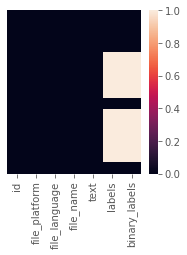

In [13]:
tweet_df = LoadDataset("Twitter.csv")

### Data Cleaning and Preprocessing

#### Handled
- Removal of Unwanted Observations
    - Remove rows with null values in labels
    - Remove unnecessary columns
    - Remove duplicates
- Fixing Structure
    - Rename column names where needed
    - Fix Data Types
- Fixing Tweet Message Structure with Text Processing
    - Remove URLs
    - Remove @ references
    - Remove special characters
    - Remove numbers
    - Remove alphanumeric words
    - emojis
- Tokenize with English Stopwords
- Apply lemmatizer
    
#### Not Handled:
- Other Language text incorrectly labelled as English
- words with incorrect whitespaces
- Meaningless words
- usernames

In [14]:
tweet_df = basic_data_cleaning(tweet_df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 126010 entries, 0 to 337746
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    126010 non-null  object
 1   labels  126010 non-null  int32 
dtypes: int32(1), object(1)
memory usage: 2.4+ MB


In [15]:
# print("==================Before Processing===============\n")
# print(tweet_df['text'].iloc[11121],"\n")
# print(tweet_df['text'].iloc[11433],"\n")
# print(tweet_df['text'].iloc[11455],"\n")
# print(tweet_df['text'].iloc[0],"\n")
# print(tweet_df['text'].iloc[1],"\n")
# print(tweet_df['text'].iloc[2],"\n")
# print(tweet_df['text'].iloc[3],"\n")
# print(tweet_df['text'].iloc[4],"\n")

tweet_df.text = tweet_df['text'].apply(data_processing, datasetType = DatasetType.TWITTER)

# print("\n\n==================After Processing===============\n")
# print(tweet_df['text'].iloc[11121],"\n")
# print(tweet_df['text'].iloc[11433],"\n")
# print(tweet_df['text'].iloc[11455],"\n")
# print(tweet_df['text'].iloc[0],"\n")
# print(tweet_df['text'].iloc[1],"\n")
# print(tweet_df['text'].iloc[2],"\n")
# print(tweet_df['text'].iloc[3],"\n")
# print(tweet_df['text'].iloc[4],"\n")

### Visualization

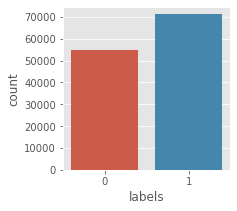

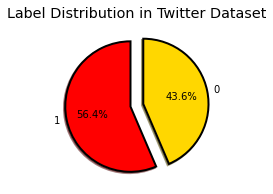

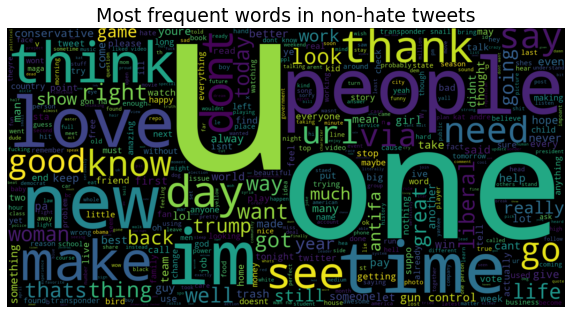

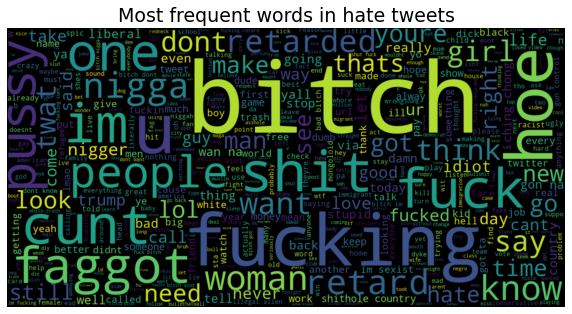

In [16]:
visualize_label_distribution(tweet_df)

#visualize most frequent words in non-hate tweets
non_hate_tweets = tweet_df[tweet_df.labels == 0]
visualize_word_cloud(non_hate_tweets['text'], "Most frequent words in non-hate tweets")

#visualize most frequent words in non-hate tweets
hate_tweets = tweet_df[tweet_df.labels == 1]
visualize_word_cloud(hate_tweets['text'], "Most frequent words in hate tweets")

### Finding the Best Model Building

============= TESTING WITH VECTORIZER  CountVectorizer()  =============
F1 Score:  0.819951844054325
Accuracy:  0.8227521625267836
Precision:  0.8204321518108924
Recall:  0.8195249667480557
============= TESTING WITH VECTORIZER  CountVectorizer(ngram_range=(1, 2))  =============
F1 Score:  0.8213500276448145
Accuracy:  0.8244186969288152
Precision:  0.8224966758444241
Recall:  0.8204483614234004
============= TESTING WITH VECTORIZER  CountVectorizer(ngram_range=(2, 2))  =============
F1 Score:  0.7529219319179952
Accuracy:  0.75791603840965
Precision:  0.7550377944122504
Recall:  0.7516460447115674
============= TESTING WITH VECTORIZER  TfidfVectorizer()  =============
F1 Score:  0.7943500514022669
Accuracy:  0.7996190778509642
Precision:  0.7997593042348373
Recall:  0.7917869869585938
============= TESTING WITH VECTORIZER  TfidfVectorizer(ngram_range=(1, 2))  =============
F1 Score:  0.8055122149788672
Accuracy:  0.8092611697484327
Precision:  0.8075496786851686
Recall:  0.80413293878

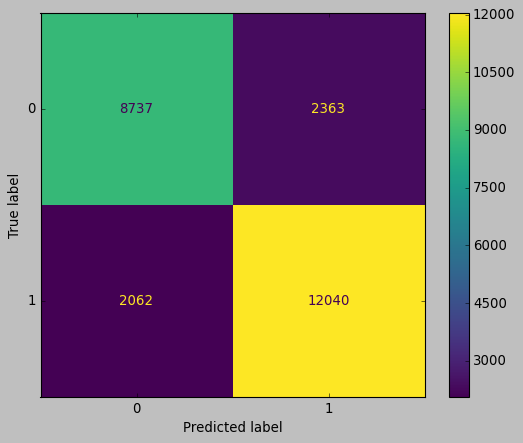

In [17]:
vectorizer = []
vectorizer.append(Vectorize(VectorizerType.COUNT, 1, 1))
vectorizer.append(Vectorize(VectorizerType.COUNT, 1, 2))
vectorizer.append(Vectorize(VectorizerType.COUNT, 2, 2))
vectorizer.append(Vectorize(VectorizerType.TFID, 1, 1))
vectorizer.append(Vectorize(VectorizerType.TFID, 1, 2))
vectorizer.append(Vectorize(VectorizerType.TFID, 2, 2))

Twitter_model = None
Twitter_vect = None
Twitter_y_test = None
Twitter_y_predict = None
score = -0.00000000001

for i in vectorizer:
    print("============= TESTING WITH VECTORIZER ", i, " =============")
    model, f1, y_test, y_predict = GenericNaiveBayes(i, tweet_df['text'], tweet_df['labels'])
    if f1 > score:
        score = f1
        Twitter_model = model
        Twitter_vect = i
        Twitter_y_test = y_test
        Twitter_y_predict = y_predict
print("\n\nBEST MODEL IS ", Twitter_model, " , ", Twitter_vect)
Confusion_Matrix(Twitter_y_test, Twitter_y_predict, Twitter_model)

### In Domain Tests

<class 'pandas.core.frame.DataFrame'>
Int64Index: 126010 entries, 0 to 337746
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    126010 non-null  object
 1   labels  126010 non-null  int32 
dtypes: int32(1), object(1)
memory usage: 2.4+ MB
F1 Score:  0.8245672964648167
Accuracy:  0.8274740099992064
Precision:  0.8254628052524517
Recall:  0.8238305281597014
              precision    recall  f1-score   support

           0       0.81      0.79      0.80     11100
           1       0.84      0.85      0.85     14102

    accuracy                           0.83     25202
   macro avg       0.83      0.82      0.82     25202
weighted avg       0.83      0.83      0.83     25202



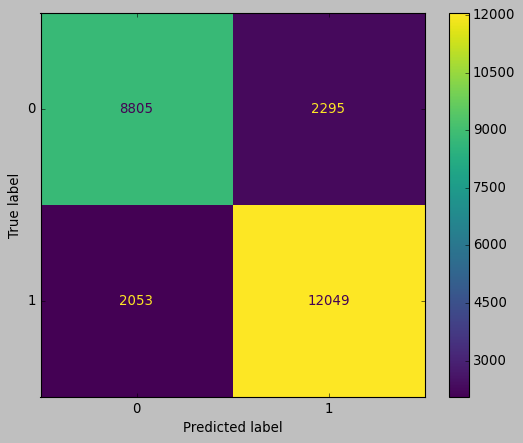

In [18]:
twitter_dataset = pd.read_csv("Twitter.csv")
twitter_dataset = basic_data_cleaning(twitter_dataset)
twitter_dataset.text = twitter_dataset['text'].apply(data_processing, datasetType = DatasetType.TWITTER)

cv = CountVectorizer(analyzer='word', ngram_range=(1, 2))
X = cv.fit_transform(twitter_dataset['text'])
Y = twitter_dataset['labels']
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

model = MultinomialNB(alpha=0.8)
model.fit(x_train, y_train)
y_predict = model.predict(x_test)

f1 = f1_score(y_test, y_predict, average='macro')
accuracy = accuracy_score(y_test, y_predict)
precision = precision_score(y_test, y_predict, average='macro')
recall = recall_score(y_test, y_predict, average='macro')

print("F1 Score: ", f1)
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)

print(classification_report(y_test, y_predict))
style.use('classic')
cm = confusion_matrix(y_test, y_predict, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()

### Cross Domain Tests

#### Train: Twitter | Test: Wiki

<class 'pandas.core.frame.DataFrame'>
Int64Index: 126010 entries, 0 to 337746
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    126010 non-null  object
 1   labels  126010 non-null  int32 
dtypes: int32(1), object(1)
memory usage: 2.4+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 196351 entries, 0 to 275535
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    196351 non-null  object
 1   labels  196351 non-null  int32 
dtypes: int32(1), object(1)
memory usage: 3.7+ MB
F1 Score:  0.7242054142009179
Accuracy:  0.881574323532857
Precision:  0.6826493269880027
Recall:  0.8309728978449831
              precision    recall  f1-score   support

           0       0.98      0.89      0.93    180271
           1       0.39      0.77      0.52     16080

    accuracy                           0.88    196351
   macro avg       0.68      0.83      0.72    1

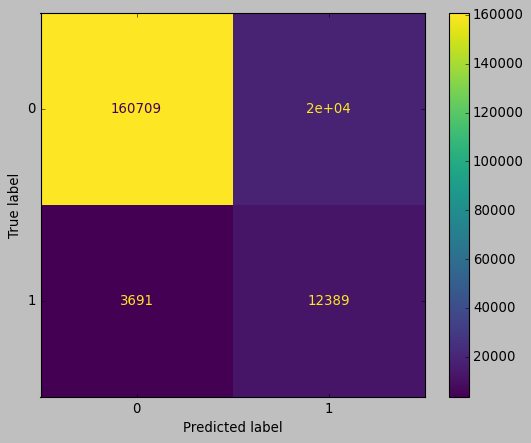

In [19]:
twitter_dataset = pd.read_csv("Twitter.csv")
twitter_dataset = basic_data_cleaning(twitter_dataset)
twitter_dataset.text = twitter_dataset['text'].apply(data_processing, datasetType = DatasetType.TWITTER)

wiki_dataset = pd.read_csv("wiki.csv")
wiki_dataset = basic_data_cleaning(wiki_dataset)
wiki_dataset.text = wiki_dataset['text'].apply(data_processing, datasetType = DatasetType.TWITTER)

cv = CountVectorizer(analyzer='word', ngram_range=(1, 2))
X_train = cv.fit_transform(twitter_dataset['text'])
Y_train = twitter_dataset['labels']
X_test = cv.transform(wiki_dataset['text'])
Y_test = wiki_dataset['labels']

model = MultinomialNB(alpha=0.8)
model.fit(X_train, Y_train)
y_predict = model.predict(X_test)

f1 = f1_score(Y_test, y_predict, average='macro')
accuracy = accuracy_score(Y_test, y_predict)
precision = precision_score(Y_test, y_predict, average='macro')
recall = recall_score(Y_test, y_predict, average='macro')

print("F1 Score: ", f1)
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)

print(classification_report(Y_test, y_predict))
style.use('classic')
cm = confusion_matrix(Y_test, y_predict, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()

# Wiki Dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 391414 entries, 0 to 391413
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             391414 non-null  int64  
 1   file_platform  391414 non-null  object 
 2   file_language  391414 non-null  object 
 3   file_name      391414 non-null  object 
 4   text           391414 non-null  object 
 5   labels         391414 non-null  object 
 6   binary_labels  391414 non-null  float64
dtypes: float64(1), int64(1), object(5)
memory usage: 20.9+ MB


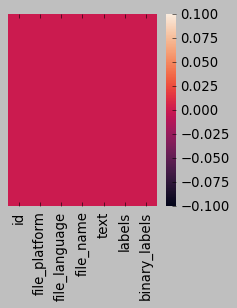

In [20]:
wiki_df = LoadDataset("wiki.csv")

In [21]:
#data cleaning
wiki_df = basic_data_cleaning(wiki_df)

# print("==================Before Processing===============\n")
# print(wiki_df['text'].iloc[11121],"\n")
# print(wiki_df['text'].iloc[11433],"\n")
# print(wiki_df['text'].iloc[11455],"\n")
# print(wiki_df['text'].iloc[0],"\n")
# print(wiki_df['text'].iloc[1],"\n")
# print(wiki_df['text'].iloc[2],"\n")
# print(wiki_df['text'].iloc[3],"\n")
# print(wiki_df['text'].iloc[4],"\n")

wiki_df.text = wiki_df['text'].apply(data_processing, datasetType = DatasetType.TWITTER)

# print("==================After Processing===============\n")
# print(wiki_df['text'].iloc[11121],"\n")
# print(wiki_df['text'].iloc[11433],"\n")
# print(wiki_df['text'].iloc[11455],"\n")
# print(wiki_df['text'].iloc[0],"\n")
# print(wiki_df['text'].iloc[1],"\n")
# print(wiki_df['text'].iloc[2],"\n")
# print(wiki_df['text'].iloc[3],"\n")
# print(wiki_df['text'].iloc[4],"\n")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 196351 entries, 0 to 275535
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    196351 non-null  object
 1   labels  196351 non-null  int32 
dtypes: int32(1), object(1)
memory usage: 3.7+ MB


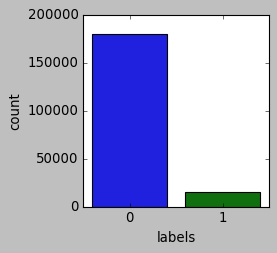

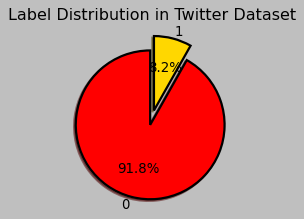

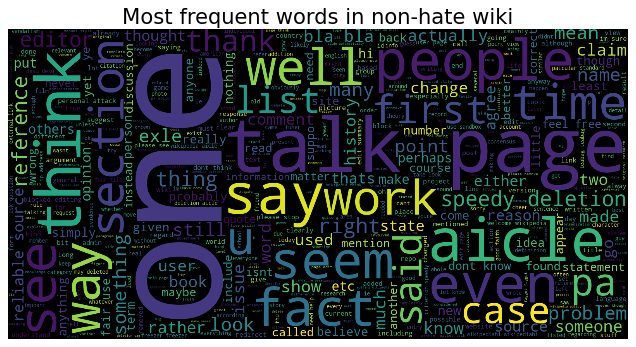

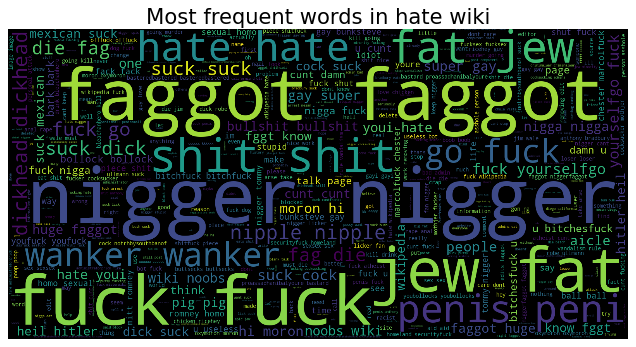

In [22]:
#visualization
visualize_label_distribution(wiki_df)

#visualize most frequent words in non-hate tweets
non_hate_wiki = wiki_df[wiki_df.labels == 0]
visualize_word_cloud(non_hate_wiki['text'], "Most frequent words in non-hate wiki")

#visualize most frequent words in non-hate tweets
hate_wiki = wiki_df[wiki_df.labels == 1]
visualize_word_cloud(hate_wiki['text'], "Most frequent words in hate wiki")

### Finding Best Model

============= TESTING WITH VECTORIZER  CountVectorizer()  =============
F1 Score:  0.8209697765743542
Accuracy:  0.9457615033994551
Precision:  0.8224196101570014
Recall:  0.8195364901055358
============= TESTING WITH VECTORIZER  CountVectorizer(ngram_range=(1, 2))  =============
F1 Score:  0.7943737103532719
Accuracy:  0.9421710677089965
Precision:  0.8215310812645882
Recall:  0.7723534823733678
============= TESTING WITH VECTORIZER  CountVectorizer(ngram_range=(2, 2))  =============
F1 Score:  0.6282535864567456
Accuracy:  0.8753023859845688
Precision:  0.6180800912974898
Recall:  0.6419540505264307
============= TESTING WITH VECTORIZER  TfidfVectorizer()  =============
F1 Score:  0.7955761141429483
Accuracy:  0.9420946754602633
Precision:  0.8199944826742005
Recall:  0.775382689972963
============= TESTING WITH VECTORIZER  TfidfVectorizer(ngram_range=(1, 2))  =============
F1 Score:  0.7345528104933234
Accuracy:  0.9421965317919075
Precision:  0.9150147608973178
Recall:  0.672006103

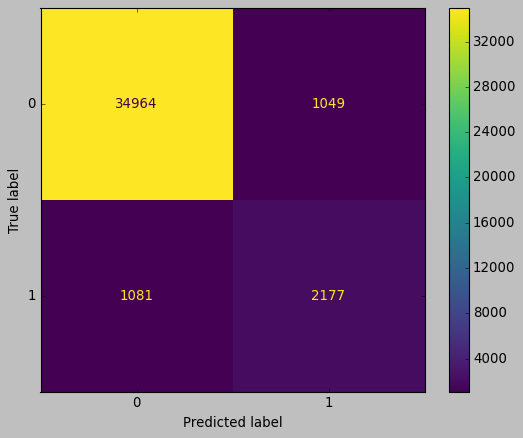

In [23]:
vectorizer = []
vectorizer.append(Vectorize(VectorizerType.COUNT, 1, 1))
vectorizer.append(Vectorize(VectorizerType.COUNT, 1, 2))
vectorizer.append(Vectorize(VectorizerType.COUNT, 2, 2))
vectorizer.append(Vectorize(VectorizerType.TFID, 1, 1))
vectorizer.append(Vectorize(VectorizerType.TFID, 1, 2))
vectorizer.append(Vectorize(VectorizerType.TFID, 2, 2))

Wiki_model = None
Wiki_vect = None
Wiki_y_test = None
Wiki_y_predict = None
score = -0.00000000001

for i in vectorizer:
    print("============= TESTING WITH VECTORIZER ", i, " =============")
    model, f1, y_test, y_predict = GenericNaiveBayes(i, wiki_df['text'], wiki_df['labels'])
    if f1 > score:
        score = f1
        Wiki_model = model
        Wiki_vect = i
        Wiki_y_test = y_test
        Wiki_y_predict = y_predict
print("\n\nBEST MODEL IS ", Wiki_model, " , ", Wiki_vect)
Confusion_Matrix(Wiki_y_test, Wiki_y_predict, Wiki_model)

### In Domain Tests

<class 'pandas.core.frame.DataFrame'>
Int64Index: 196351 entries, 0 to 275535
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    196351 non-null  object
 1   labels  196351 non-null  int32 
dtypes: int32(1), object(1)
memory usage: 3.7+ MB
F1 Score:  0.8211504940925808
Accuracy:  0.9461434646431208
Precision:  0.8246025502431902
Recall:  0.8177905650911101
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     36013
           1       0.68      0.66      0.67      3258

    accuracy                           0.95     39271
   macro avg       0.82      0.82      0.82     39271
weighted avg       0.95      0.95      0.95     39271



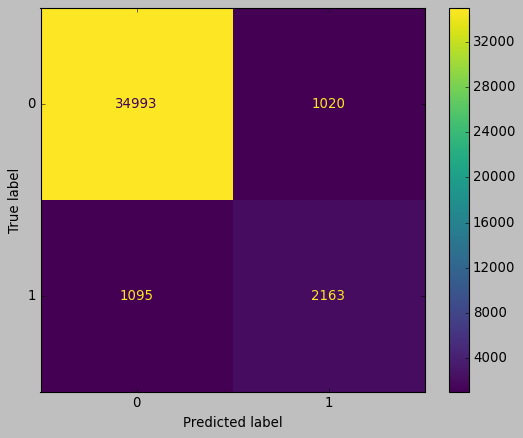

In [24]:
wiki_dataset = pd.read_csv("wiki.csv")
wiki_dataset = basic_data_cleaning(wiki_dataset)
wiki_dataset.text = wiki_dataset['text'].apply(data_processing, datasetType = DatasetType.TWITTER)

cv = CountVectorizer(analyzer='word', ngram_range=(1, 1))
X = cv.fit_transform(wiki_dataset['text'])
Y = wiki_dataset['labels']
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

model = MultinomialNB(alpha=0.2)
model.fit(x_train, y_train)
y_predict = model.predict(x_test)

f1 = f1_score(y_test, y_predict, average='macro')
accuracy = accuracy_score(y_test, y_predict)
precision = precision_score(y_test, y_predict, average='macro')
recall = recall_score(y_test, y_predict, average='macro')

print("F1 Score: ", f1)
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)

print(classification_report(y_test, y_predict))
style.use('classic')
cm = confusion_matrix(y_test, y_predict, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()

### Cross Domain Tests

#### Train: Wiki | Test: Twitter

<class 'pandas.core.frame.DataFrame'>
Int64Index: 126010 entries, 0 to 337746
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    126010 non-null  object
 1   labels  126010 non-null  int32 
dtypes: int32(1), object(1)
memory usage: 2.4+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 196351 entries, 0 to 275535
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    196351 non-null  object
 1   labels  196351 non-null  int32 
dtypes: int32(1), object(1)
memory usage: 3.7+ MB
F1 Score:  0.761624140630593
Accuracy:  0.7622966431235616
Precision:  0.7936588107876594
Recall:  0.7821165726058135
              precision    recall  f1-score   support

           0       0.66      0.94      0.77     54889
           1       0.93      0.63      0.75     71121

    accuracy                           0.76    126010
   macro avg       0.79      0.78      0.76    1

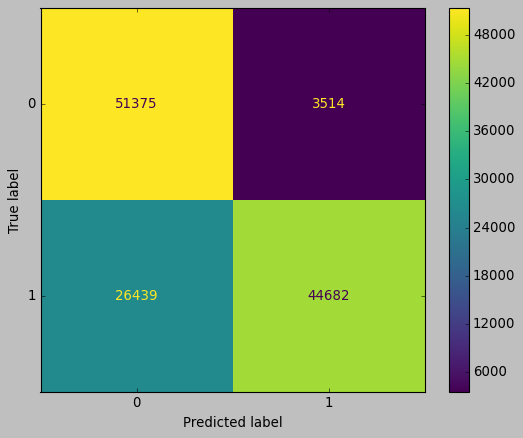

In [25]:
twitter_dataset = pd.read_csv("Twitter.csv")
twitter_dataset = basic_data_cleaning(twitter_dataset)
twitter_dataset.text = twitter_dataset['text'].apply(data_processing, datasetType = DatasetType.TWITTER)

wiki_dataset = pd.read_csv("wiki.csv")
wiki_dataset = basic_data_cleaning(wiki_dataset)
wiki_dataset.text = wiki_dataset['text'].apply(data_processing, datasetType = DatasetType.TWITTER)

cv = CountVectorizer(analyzer='word', ngram_range=(1, 1))
X_train = cv.fit_transform(wiki_dataset['text'])
Y_train = wiki_dataset['labels']
X_test = cv.transform(twitter_dataset['text'])
Y_test = twitter_dataset['labels']

model = MultinomialNB(alpha=0.2)
model.fit(X_train, Y_train)
y_predict = model.predict(X_test)

f1 = f1_score(Y_test, y_predict, average='macro')
accuracy = accuracy_score(Y_test, y_predict)
precision = precision_score(Y_test, y_predict, average='macro')
recall = recall_score(Y_test, y_predict, average='macro')

print("F1 Score: ", f1)
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)

print(classification_report(Y_test, y_predict))
style.use('classic')
cm = confusion_matrix(Y_test, y_predict, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()

# Fox Dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1528 entries, 0 to 1527
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1528 non-null   int64  
 1   file_platform  1528 non-null   object 
 2   file_language  1528 non-null   object 
 3   file_name      1528 non-null   object 
 4   text           1528 non-null   object 
 5   labels         1528 non-null   object 
 6   binary_labels  1528 non-null   float64
dtypes: float64(1), int64(1), object(5)
memory usage: 83.7+ KB


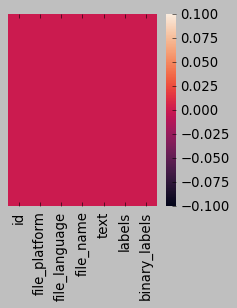

In [26]:
fox_df = LoadDataset("fox.csv")

In [27]:
fox_df = basic_data_cleaning(fox_df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1520 entries, 0 to 1527
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1520 non-null   object
 1   labels  1520 non-null   int32 
dtypes: int32(1), object(1)
memory usage: 29.7+ KB


In [30]:
# print("==================Before Processing===============\n")
# print(fox_df['text'].iloc[0],"\n")
# print(fox_df['text'].iloc[1],"\n")
# print(fox_df['text'].iloc[2],"\n")
# print(fox_df['text'].iloc[3],"\n")
# print(fox_df['text'].iloc[4],"\n")

fox_df.text = fox_df['text'].apply(data_processing, datasetType = DatasetType.TWITTER)

# print("==================After Processing===============\n")
# print(fox_df['text'].iloc[0],"\n")
# print(fox_df['text'].iloc[1],"\n")
# print(fox_df['text'].iloc[2],"\n")
# print(fox_df['text'].iloc[3],"\n")
# print(fox_df['text'].iloc[4],"\n")

==================Before Processing===============

Merkel would never say NO 

Expect more and more women to be asking .. "why are men no longer interested in me"! We're not going touch you until you pull our pants down! 

Groping people in public wasn't already illegal? What's up with that, Deutschland? 

Merkel, possible the only person in charge who is worse than what we have. Obama is trying his hardest though to get to Merkel's level. "A 21-year-old Iraqi man was convicted of sexual assault and given a one-year suspended sentence. A 26-year-old Algerian man was convicted of abetting a sexual assault and attempted assault, and given the same sentence." Sounds exactly like how Obama is trying to let all of the black people in this country get away with everything. 

They know very well, no means NO! They need to pass a law making it legal to castrate those animals. 

==================After Processing===============

merkel would never say 

expect woman asking men longer intereste

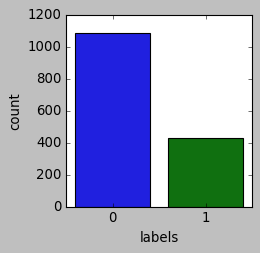

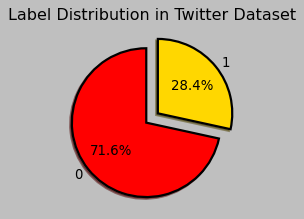

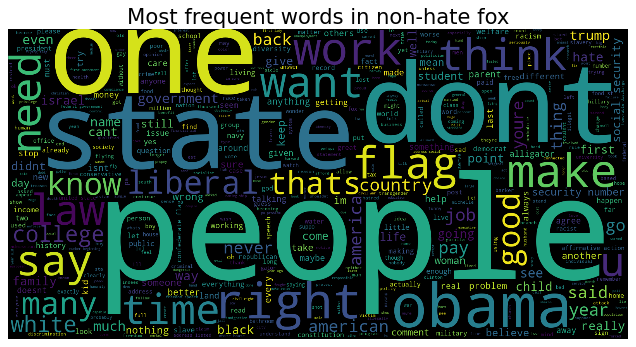

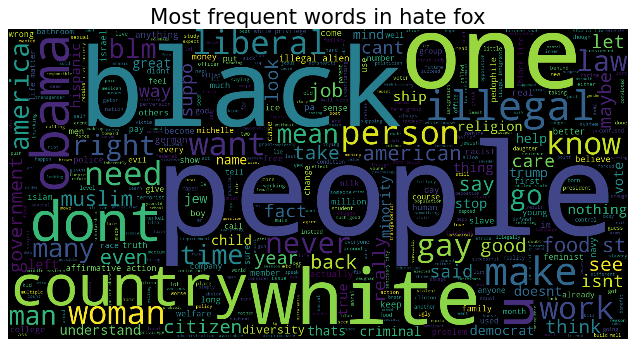

In [32]:
visualize_label_distribution(fox_df)

#visualize most frequent words in non-hate tweets
non_hate_fox = fox_df[fox_df.labels == 0]
visualize_word_cloud(non_hate_fox['text'], "Most frequent words in non-hate fox")

#visualize most frequent words in non-hate tweets
hate_fox = fox_df[fox_df.labels == 1]
visualize_word_cloud(hate_fox['text'], "Most frequent words in hate fox")

### Finding the Best Model Building

============= TESTING WITH VECTORIZER  CountVectorizer()  =============
F1 Score:  0.6622711684296962
Accuracy:  0.6973684210526315
Precision:  0.6581101190476191
Recall:  0.6722391084093212
============= TESTING WITH VECTORIZER  CountVectorizer(ngram_range=(1, 2))  =============
F1 Score:  0.6446027946334132
Accuracy:  0.6546052631578947
Precision:  0.663738885274344
Recall:  0.6912360688956434
============= TESTING WITH VECTORIZER  CountVectorizer(ngram_range=(2, 2))  =============
F1 Score:  0.5875261355042485
Accuracy:  0.5986842105263158
Precision:  0.6090277777777777
Recall:  0.6272543059777103
============= TESTING WITH VECTORIZER  TfidfVectorizer()  =============
F1 Score:  0.6718153130709186
Accuracy:  0.743421052631579
Precision:  0.6986540378863411
Recall:  0.661499493414387
============= TESTING WITH VECTORIZER  TfidfVectorizer(ngram_range=(1, 2))  =============
F1 Score:  0.7060883198327671
Accuracy:  0.756578947368421
Precision:  0.7140692640692641
Recall:  0.700405268490

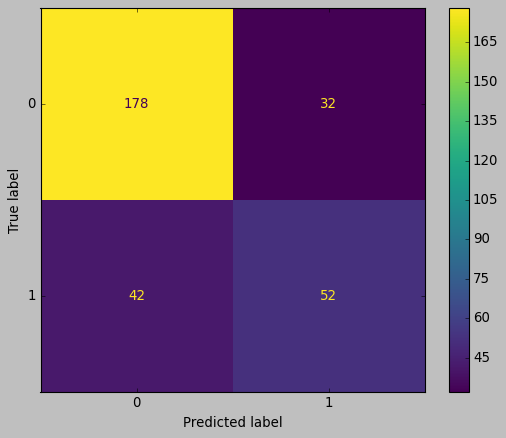

In [33]:
vectorizer = []
vectorizer.append(Vectorize(VectorizerType.COUNT, 1, 1))
vectorizer.append(Vectorize(VectorizerType.COUNT, 1, 2))
vectorizer.append(Vectorize(VectorizerType.COUNT, 2, 2))
vectorizer.append(Vectorize(VectorizerType.TFID, 1, 1))
vectorizer.append(Vectorize(VectorizerType.TFID, 1, 2))
vectorizer.append(Vectorize(VectorizerType.TFID, 2, 2))

Fox_model = None
Fox_vect = None
Fox_y_test = None
Fox_y_predict = None
score = -0.00000000001

for i in vectorizer:
    print("============= TESTING WITH VECTORIZER ", i, " =============")
    model, f1, y_test, y_predict = GenericNaiveBayes(i, fox_df['text'], fox_df['labels'])
    if f1 > score:
        score = f1
        Fox_model = model
        Fox_vect = i
        Fox_y_test = y_test
        Fox_y_predict = y_predict
print("\n\nBEST MODEL IS ", Fox_model, " , ", Fox_vect)
Confusion_Matrix(Fox_y_test, Fox_y_predict, Fox_model)

### In Domain Test

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1520 entries, 0 to 1527
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1520 non-null   object
 1   labels  1520 non-null   int32 
dtypes: int32(1), object(1)
memory usage: 29.7+ KB
F1 Score:  0.7001560646732006
Accuracy:  0.7401315789473685
Precision:  0.6976348854397635
Recall:  0.7031914893617022
              precision    recall  f1-score   support

           0       0.82      0.80      0.81       210
           1       0.58      0.61      0.59        94

    accuracy                           0.74       304
   macro avg       0.70      0.70      0.70       304
weighted avg       0.74      0.74      0.74       304



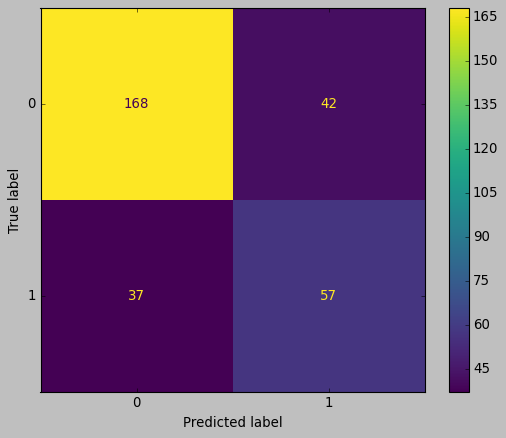

In [34]:
fox_dataset = pd.read_csv("fox.csv")
fox_dataset = basic_data_cleaning(fox_dataset)
fox_dataset.text = fox_dataset['text'].apply(data_processing, datasetType = DatasetType.TWITTER)

cv = TfidfVectorizer(analyzer='word', ngram_range=(1,2))
X = cv.fit_transform(fox_dataset['text'])
Y = fox_dataset['labels']
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

model = MultinomialNB(alpha=0.1)
model.fit(x_train, y_train)
y_predict = model.predict(x_test)

f1 = f1_score(y_test, y_predict, average='macro')
accuracy = accuracy_score(y_test, y_predict)
precision = precision_score(y_test, y_predict, average='macro')
recall = recall_score(y_test, y_predict, average='macro')

print("F1 Score: ", f1)
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)

print(classification_report(y_test, y_predict))
style.use('classic')
cm = confusion_matrix(y_test, y_predict, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()

### Cross Domain Tests

#### Train: Fox | Test: Twitter

<class 'pandas.core.frame.DataFrame'>
Int64Index: 126010 entries, 0 to 337746
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    126010 non-null  object
 1   labels  126010 non-null  int32 
dtypes: int32(1), object(1)
memory usage: 2.4+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1520 entries, 0 to 1527
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1520 non-null   object
 1   labels  1520 non-null   int32 
dtypes: int32(1), object(1)
memory usage: 29.7+ KB
F1 Score:  0.3841541177033754
Accuracy:  0.4607094675025792
Precision:  0.547366528522979
Recall:  0.5146665435771504
              precision    recall  f1-score   support

           0       0.44      0.93      0.60     54889
           1       0.65      0.10      0.17     71121

    accuracy                           0.46    126010
   macro avg       0.55      0.51      0.38    126010
w

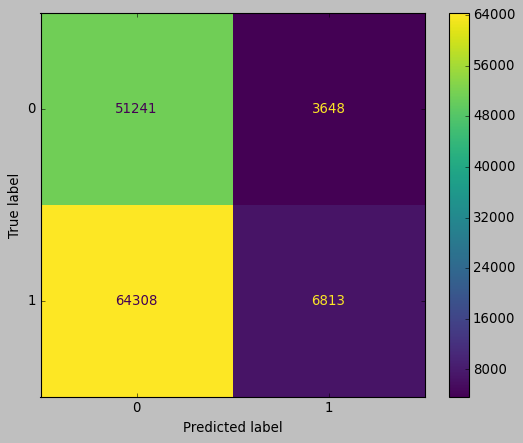

In [35]:
twitter_dataset = pd.read_csv("Twitter.csv")
twitter_dataset = basic_data_cleaning(twitter_dataset)
twitter_dataset.text = twitter_dataset['text'].apply(data_processing, datasetType = DatasetType.TWITTER)

fox_dataset = pd.read_csv("fox.csv")
fox_dataset = basic_data_cleaning(fox_dataset)
fox_dataset.text = fox_dataset['text'].apply(data_processing, datasetType = DatasetType.TWITTER)

cv = TfidfVectorizer(analyzer='word', ngram_range=(1,2))
X_train = cv.fit_transform(fox_dataset['text'])
Y_train = fox_dataset['labels']
X_test = cv.transform(twitter_dataset['text'])
Y_test = twitter_dataset['labels']

model = MultinomialNB(alpha=0.1)
model.fit(X_train, Y_train)
y_predict = model.predict(X_test)

f1 = f1_score(Y_test, y_predict, average='macro')
accuracy = accuracy_score(Y_test, y_predict)
precision = precision_score(Y_test, y_predict, average='macro')
recall = recall_score(Y_test, y_predict, average='macro')

print("F1 Score: ", f1)
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)

print(classification_report(Y_test, y_predict))
style.use('classic')
cm = confusion_matrix(Y_test, y_predict, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()

#### Train: Fox | Test: Wiki

<class 'pandas.core.frame.DataFrame'>
Int64Index: 196351 entries, 0 to 275535
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    196351 non-null  object
 1   labels  196351 non-null  int32 
dtypes: int32(1), object(1)
memory usage: 3.7+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1520 entries, 0 to 1527
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1520 non-null   object
 1   labels  1520 non-null   int32 
dtypes: int32(1), object(1)
memory usage: 29.7+ KB
F1 Score:  0.9959490842531844
Accuracy:  0.9967105263157895
Precision:  0.9970013182662129
Recall:  0.9949108115468409
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1088
           1       1.00      0.99      0.99       432

    accuracy                           1.00      1520
   macro avg       1.00      0.99      1.00      1520


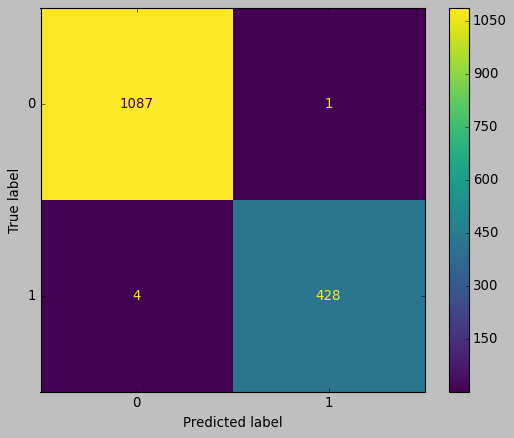

In [36]:
wiki_dataset = pd.read_csv("wiki.csv")
wiki_dataset = basic_data_cleaning(wiki_dataset)
wiki_dataset.text = wiki_dataset['text'].apply(data_processing, datasetType = DatasetType.TWITTER)

fox_dataset = pd.read_csv("fox.csv")
fox_dataset = basic_data_cleaning(fox_dataset)
fox_dataset.text = fox_dataset['text'].apply(data_processing, datasetType = DatasetType.TWITTER)

cv = TfidfVectorizer(analyzer='word', ngram_range=(1,2))
X_train = cv.fit_transform(fox_dataset['text'])
Y_train = fox_dataset['labels']
X_test = cv.transform(fox_dataset['text'])
Y_test = fox_dataset['labels']

model = MultinomialNB(alpha=0.1)
model.fit(X_train, Y_train)
y_predict = model.predict(X_test)

f1 = f1_score(Y_test, y_predict, average='macro')
accuracy = accuracy_score(Y_test, y_predict)
precision = precision_score(Y_test, y_predict, average='macro')
recall = recall_score(Y_test, y_predict, average='macro')

print("F1 Score: ", f1)
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)

print(classification_report(Y_test, y_predict))
style.use('classic')
cm = confusion_matrix(Y_test, y_predict, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()